In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import causal_convolution_layer
import Dataloader

In [2]:
import math
from torch.utils.data import DataLoader

In [3]:
class TransformerTimeSeries(torch.nn.Module):
    """
    Time Series application of transformers based on paper
    
    causal_convolution_layer parameters:
        in_channels: the number of features per time point
        out_channels: the number of features outputted per time point
        kernel_size: k is the width of the 1-D sliding kernel
        
    nn.Transformer parameters:
        d_model: the size of the embedding vector (input)
    
    PositionalEncoding parameters:
        d_model: the size of the embedding vector (positional vector)
        dropout: the dropout to be used on the sum of positional+embedding vector
    
    """
    def __init__(self):
        super(TransformerTimeSeries,self).__init__()
        self.input_embedding = causal_convolution_layer.context_embedding(2,256,9)
        self.positional_embedding = torch.nn.Embedding(512,256)

        
        self.decode_layer = torch.nn.TransformerEncoderLayer(d_model=256,nhead=8)
        self.transformer_decoder = torch.nn.TransformerEncoder(self.decode_layer, num_layers=3)
        
        self.fc1 = torch.nn.Linear(256,1)
        
    def forward(self,x,y,attention_masks):
        
        # concatenate observed points and time covariate
        # (B*feature_size*n_time_points)
        z = torch.cat((y.unsqueeze(1),x.unsqueeze(1)),1)

        # input_embedding returns shape (Batch size,embedding size,sequence len) -> need (sequence len,Batch size,embedding_size)
        z_embedding = self.input_embedding(z).permute(2,0,1)
        
        # get my positional embeddings (Batch size, sequence_len, embedding_size) -> need (sequence len,Batch size,embedding_size)
        positional_embeddings = self.positional_embedding(x.type(torch.long)).permute(1,0,2)
        
        input_embedding = z_embedding+positional_embeddings
        
        transformer_embedding = self.transformer_decoder(input_embedding,attention_masks)

        output = self.fc1(transformer_embedding.permute(1,0,2))
        
        return output
        

In [4]:
train_dataset = Dataloader.time_series_decoder_paper(96,4500)
validation_dataset = Dataloader.time_series_decoder_paper(96,500)
test_dataset = Dataloader.time_series_decoder_paper(96,1000)

x: 4500*120 fx: 4500*120
x: 500*120 fx: 500*120
x: 1000*120 fx: 1000*120


In [5]:
criterion = torch.nn.MSELoss()

In [6]:
train_dl = DataLoader(train_dataset,batch_size=32,shuffle=True)
validation_dl = DataLoader(validation_dataset,batch_size=64)
test_dl = DataLoader(test_dataset,batch_size=128)

In [7]:
model = TransformerTimeSeries().cuda()

In [8]:
lr = .0005 # learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 100

In [9]:
def Dp(y_pred,y_true,q):
    return max([q*(y_pred-y_true),(q-1)*(y_pred-y_true)])


In [10]:
def Rp_num_den(y_preds,y_trues,q):
    numerator = np.sum([Dp(y_pred,y_true,q) for y_pred,y_true in zip(y_preds,y_trues)])
    denominator = np.sum([np.abs(y_true) for y_true in y_trues])
    return numerator,denominator

In [11]:
def train_epoch(model,train_dl,t0=96):
    model.train()
    train_loss = 0
    n = 0
    for step,(x,y,attention_masks) in enumerate(train_dl):
        optimizer.zero_grad()
        output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
        loss = criterion(output.squeeze()[:,(t0-1):(t0+24-1)],y.cuda()[:,t0:])        
        loss.backward()
        optimizer.step()
        
        train_loss += (loss.detach().cpu().item() * x.shape[0])
        n += x.shape[0]
    return train_loss/n

In [12]:
def eval_epoch(model,validation_dl,t0=96):
    model.eval()
    eval_loss = 0
    n = 0
    with torch.no_grad():
        for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())
            loss = criterion(output.squeeze()[:,(t0-1):(t0+24-1)],y.cuda()[:,t0:])
            
            eval_loss += (loss.detach().cpu().item() * x.shape[0])
            n += x.shape[0]
            
    return eval_loss/n

In [13]:
def test_epoch(model,test_dl,t0=96):
    with torch.no_grad():
        predictions = []
        observations = []

        model.eval()
        for step,(x,y,attention_masks) in enumerate(test_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            for p,o in zip(output.squeeze()[:,(t0-1):(t0+24-1)].cpu().numpy().tolist(),y.cuda()[:,t0:].cpu().numpy().tolist()):

                predictions.append(p)
                observations.append(o)

        num = 0
        den = 0
        for y_preds,y_trues in zip(predictions,observations):
            num_i,den_i = Rp_num_den(y_preds,y_trues,.5)
            num+=num_i
            den+=den_i
        Rp = (2*num)/den
        
    return Rp

In [14]:
train_dataset[0][-1][96]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf])

In [15]:
train_epoch_loss = []
eval_epoch_loss = []
Rp_best = 10
for e,epoch in enumerate(range(epochs)):
    train_loss = []
    eval_loss = []
    
    l_t = train_epoch(model,train_dl)
    train_loss.append(l_t)
    
    l_e = eval_epoch(model,validation_dl)
    eval_loss.append(l_e)
    
    Rp = test_epoch(model,test_dl)

    if Rp_best > Rp:
        Rp_best = Rp
        
    train_epoch_loss.append(np.mean(train_loss))
    eval_epoch_loss.append(np.mean(eval_loss))
    
    print("Epoch {}: Train loss: {} \t Validation loss: {} \t R_p={}".format(e,
                                                             np.mean(train_loss),
                                                             np.mean(eval_loss),Rp))

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0: Train loss: 3788.7322235243055 	 Validation loss: 2641.154841796875 	 R_p=0.6002164436251692
Epoch 1: Train loss: 1861.8889606119792 	 Validation loss: 1255.0450322265624 	 R_p=0.40767152703895576
Epoch 2: Train loss: 764.3106196831598 	 Validation loss: 410.83806298828125 	 R_p=0.17750108641797807
Epoch 3: Train loss: 267.77281248643664 	 Validation loss: 159.37313647460937 	 R_p=0.10417964726001977
Epoch 4: Train loss: 107.80671404690213 	 Validation loss: 63.359057556152344 	 R_p=0.05629999476331858
Epoch 5: Train loss: 47.435913501315646 	 Validation loss: 29.435648696899413 	 R_p=0.03867550944712315
Epoch 6: Train loss: 23.476484204610188 	 Validation loss: 15.469348754882812 	 R_p=0.029478874380619934
Epoch 7: Train loss: 13.295403647528754 	 Validation loss: 9.545552261352539 	 R_p=0.026272060400807887
Epoch 8: Train loss: 8.353910311381021 	 Validation loss: 6.161325263977051 	 R_p=0.02224599424981212
Epoch 9: Train loss: 5.675639579137166 	 Validation loss: 3.85044737

Epoch 78: Train loss: 1.2815967530144585 	 Validation loss: 1.4862075090408324 	 R_p=0.013642804397576707
Epoch 79: Train loss: 1.3282761347028944 	 Validation loss: 1.248135766029358 	 R_p=0.012400926948673395
Epoch 80: Train loss: 1.3209631043540107 	 Validation loss: 1.3131959705352783 	 R_p=0.012649049681974662
Epoch 81: Train loss: 1.3102116330464681 	 Validation loss: 1.72548690700531 	 R_p=0.014456559417690747
Epoch 82: Train loss: 1.2869963954289754 	 Validation loss: 1.3974910049438476 	 R_p=0.01306891553842673
Epoch 83: Train loss: 1.260964007165697 	 Validation loss: 1.4528732290267945 	 R_p=0.013341732056746115
Epoch 84: Train loss: 1.2829057622485691 	 Validation loss: 1.516860746383667 	 R_p=0.013672876970677041
Epoch 85: Train loss: 1.2672195434570312 	 Validation loss: 1.3666997375488281 	 R_p=0.012957468265480358
Epoch 86: Train loss: 1.3243287380006579 	 Validation loss: 1.185442237854004 	 R_p=0.012114130071501724
Epoch 87: Train loss: 1.2930065610673693 	 Validation

In [16]:
print("Rp best={}".format(Rp_best))

0.012114130071501724


## Visualize the data

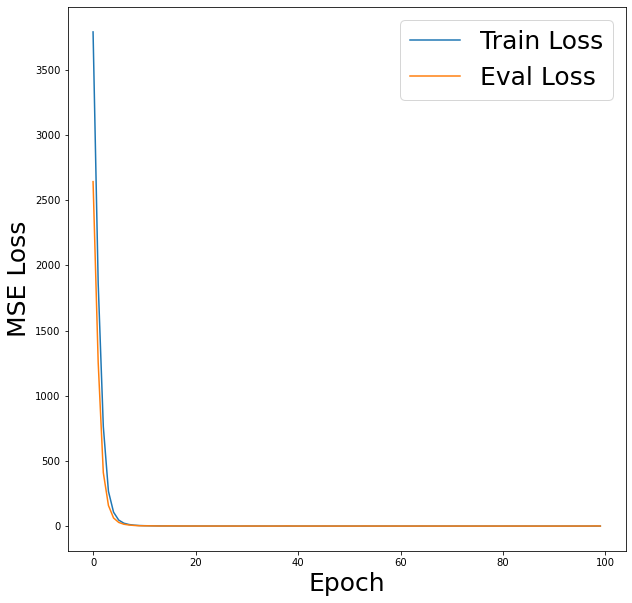

In [17]:
plt.figure(figsize=(10,10))
plt.plot(train_epoch_loss)
plt.plot(eval_epoch_loss)
plt.legend(['Train Loss','Eval Loss'],fontsize=25)
plt.xlabel("Epoch",fontsize=25)
plt.ylabel("MSE Loss",fontsize=25)
plt.show()

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


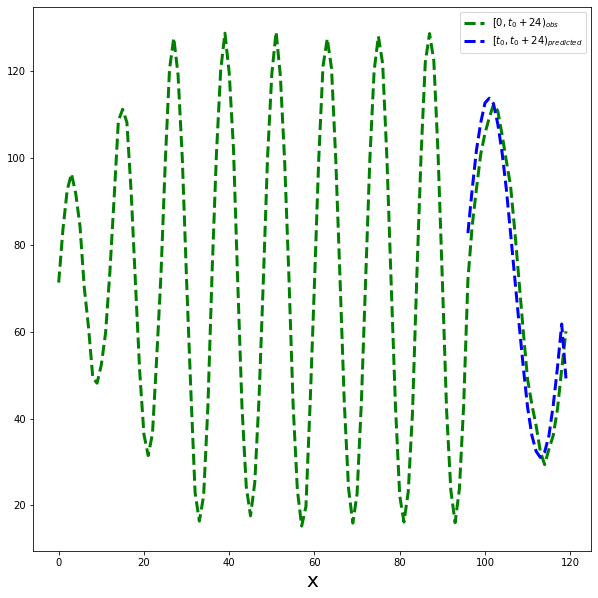

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


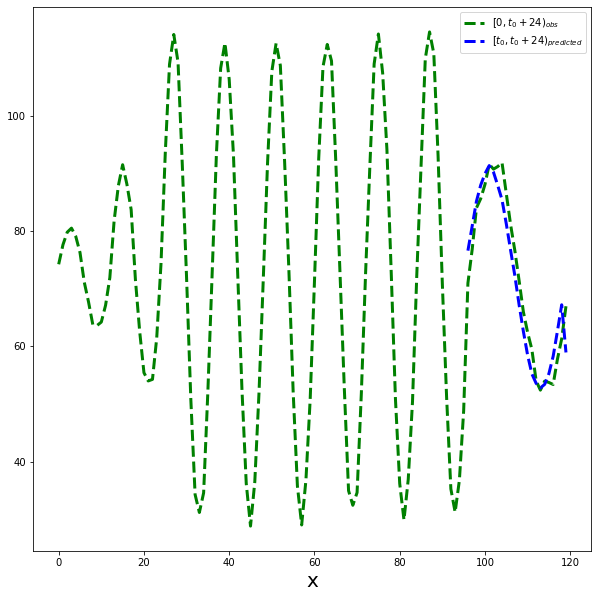

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


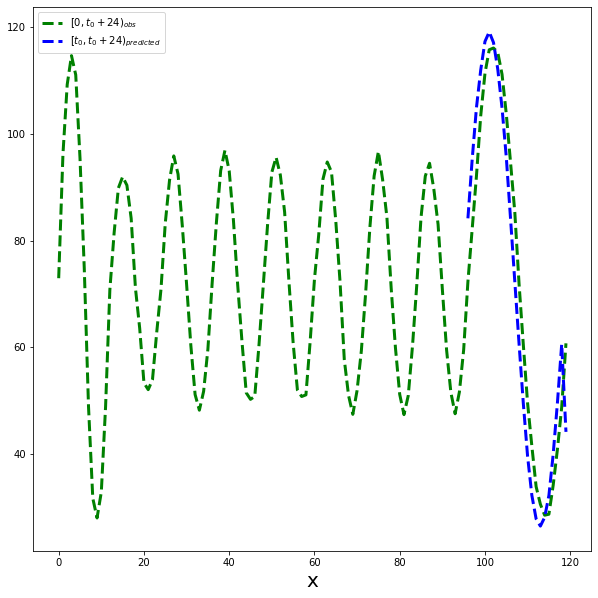

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


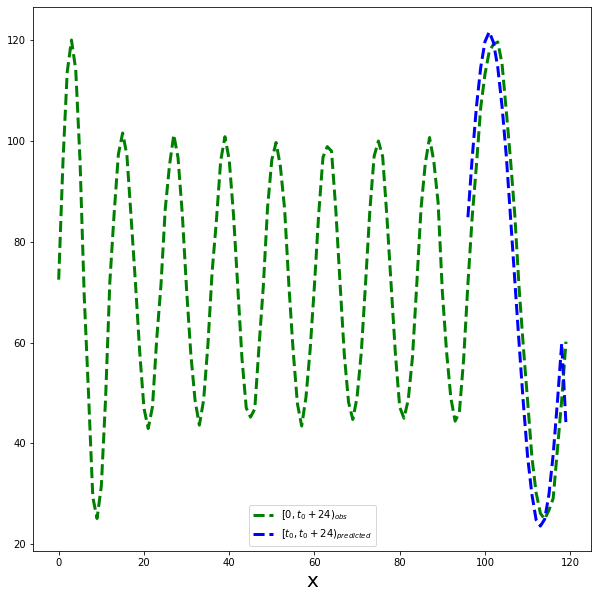

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


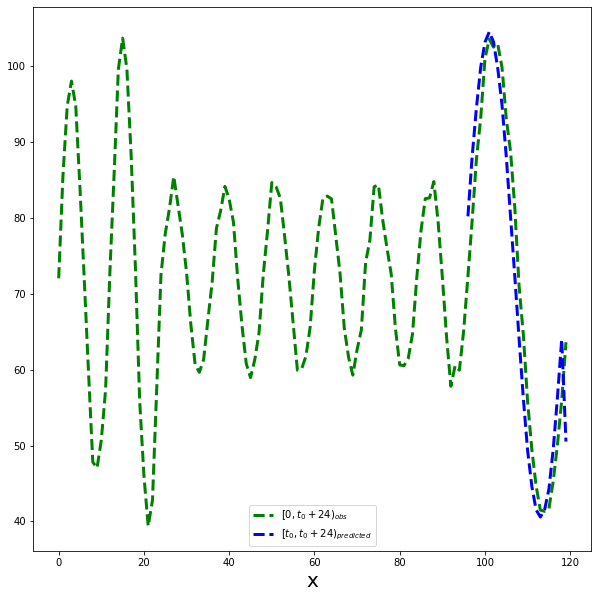

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


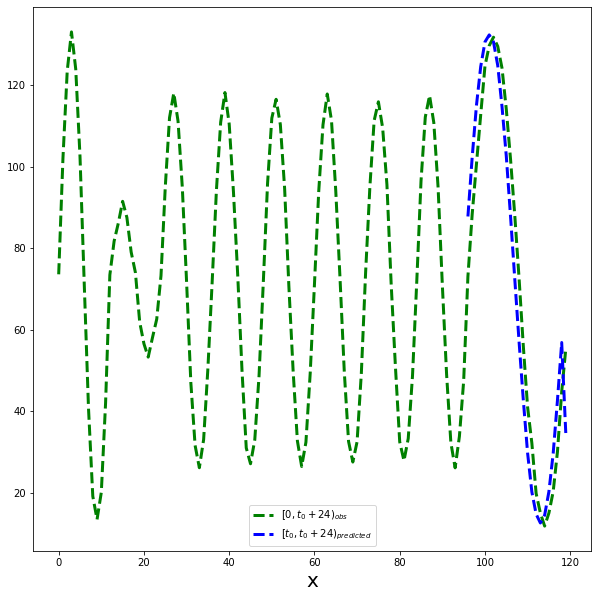

C:\Users\lpott\anaconda3\envs\NLP\lib\site-packages\torch\nn\functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [20]:
n_plots = 5
t0 = 96
with torch.no_grad():
    model.eval()
    for step,(x,y,attention_masks) in enumerate(validation_dl):
            output = model(x.cuda(),y.cuda(),attention_masks[0].cuda())

            if step > n_plots:
                break

            with torch.no_grad():
                plt.figure(figsize=(10,10))
                plt.plot(x[0].cpu().detach().squeeze().numpy(),y[0].cpu().detach().squeeze().numpy(),'g--',linewidth=3)
                plt.plot(x[0,t0:].cpu().detach().squeeze().numpy(),output[0,(t0-1):(t0+24-1)].cpu().detach().squeeze().numpy(),'b--',linewidth=3)

                plt.xlabel("x",fontsize=20)
                plt.legend(["$[0,t_0+24)_{obs}$","$[t_0,t_0+24)_{predicted}$"])
                plt.show()
